In [35]:
###=== Import modules which are used in this note & global setup ===###
    
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt

import plotly.offline    as offline
import plotly.graph_objs as go
offline.init_notebook_mode(connected=True)

# True for hide code-sell while output to HTML
if (True):
    from   IPython.display      import display, HTML
    import IPython.core.display as di
    di.display_html('<script>jQuery(function() '+
                    '{if (jQuery("body.notebook_app").length == 0) '+
                    '{ jQuery(".input_area").toggle(); '+
                    'jQuery(".prompt").toggle();}});</script>', raw=True)
    di.display_html('''<button onclick="jQuery('.input_area').toggle(); '''+
                    '''jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

import sys, os
sys.path.append("/home/miyamoto/python_code-set/lib")
from misc_QM.special_functions   import sph_harm_xyz
from lattice.rotation_projection import rot_proj
from lattice.calc_laplacian      import lap, lap_4th_proc

show_graph = False

Toggle code

In [2]:
###=== The function for making reduced (A1) r-coordinate data ===###
# idata[x,y,z] = value
# odata[0,:] = r-coordinate, odata[1,:] = value
def make_rd(idata):
    iNd = len(idata[0,0,:])
    o_r = []
    o_d = []
    for z in range(iNd//2+1):
        for y in range(z+1):
            for x in range(y+1):
                o_r.append(np.sqrt(x**2+y**2+z**2))
                o_d.append(idata[z,y,x])
    return np.array((o_r,o_d))

In [3]:
###=== The function for making r-binning data ===###
# idata[0,:] = r-coordinate, idata[1,:] = value
# odata[0,:] = r-coordinate, odata[1,:] = value, odata[2,:] = xerr, odata[3,:] = yerr
def rbin(idata, bsize = 1):
    iNd = len(idata[0,:])
    o_r = []
    o_d = []
    ore = []
    ode = []
    for r in np.arange(0.0, np.max(idata[0,:]), bsize):
        idcs = np.where((r<=idata[0,:]) & (idata[0,:]<r+bsize))[0]
        Nb   = len(idcs)
        if (Nb != 0):
            br  = np.sum(idata[0,idcs]   ) / float(Nb)
            br2 = np.sum(idata[0,idcs]**2) / float(Nb)
            bd  = np.sum(idata[1,idcs]   ) / float(Nb)
            bd2 = np.sum(idata[1,idcs]**2) / float(Nb)
            o_r.append(br)
            o_d.append(bd)
            if (Nb == 1):
                ore.append(0.0)
                ode.append(0.0)
            else:
                ore.append(np.sqrt(br2-br**2)/np.sqrt(Nb-1))
                ode.append(np.sqrt(bd2-bd**2)/np.sqrt(Nb-1))
    return np.array((o_r,o_d,ore,ode))

# Mock up wave function data

* I define the wave function by
<font size=3 color=red>
\begin{equation}
\psi(r) = \exp\left[ -\frac{r^2}{60} \right]+3,
\end{equation}
</font>
where $r = \sqrt{x^2+y^2+z^2}$


* Then, potential is defined as
<font size=3 color=red>
\begin{equation}
V(r) = \frac{\nabla^2 \psi(r)}{\psi(r)}
\end{equation}
</font>

## Data setup

* Lattice: $(L_x,L_y,L_z) = (96,96,96)$ with the <font color='red'>periodic boundary condition</font>

In [4]:
Ls   = 96
Larr = np.arange(Ls, dtype=int)
Lpbc = np.array([(i if i < Ls//2 else i-Ls) for i in Larr], dtype=int)
rcrd = np.array([[np.sqrt(Lpbc**2 + Lpbc[y]**2 + Lpbc[z]**2) for y in Larr] for z in Larr])

In [5]:
###=== Generate a mock up wave function on the 3D-lattice ===###

psi  = np.array([[-np.exp(-(Lpbc**2+Lpbc[y]**2+Lpbc[z]**2)/60.0) + 3.0 for y in Larr] for z in Larr])

In [6]:
###=== Generate a mock up potential on the 3D-lattice ===###

pot = lap_4th_proc(psi)/psi

## Plot: 2-D plot for the $\psi(r)$ and $V(r)$

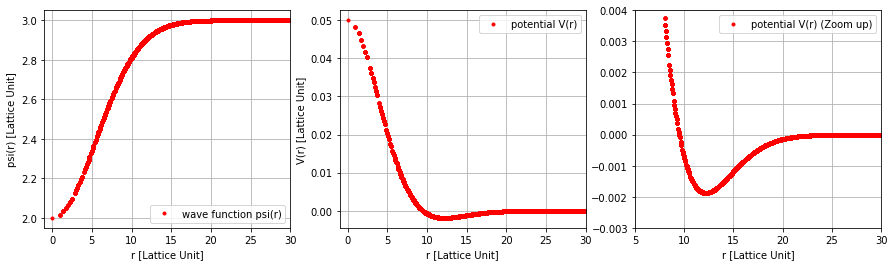

In [7]:
###=== 2-D plot for the psi(r) and V(r) ===###

if (show_graph or True):
    r_flt    = rcrd.flatten()
    fig, axe = plt.subplots(ncols=3, figsize=(15,4))
    axe[0].plot(r_flt,psi.flatten(),'r.', label='wave function psi(r)')
    axe[1].plot(r_flt,pot.flatten(),'r.', label='potential V(r)')
    axe[2].plot(r_flt,pot.flatten(),'r.', label='potential V(r) (Zoom up)')
    axe[0].set_xlim(-1,30)
    axe[1].set_xlim(-1,30)
    axe[2].set_xlim(5,30)
    axe[2].set_ylim(-3e-3,4e-3)
    axe[0].legend(numpoints=1, loc='lower right')
    axe[1].legend(numpoints=1, loc='upper right')
    axe[2].legend(numpoints=1, loc='upper right')
    axe[0].set_ylabel('psi(r) [Lattice Unit]')
    axe[1].set_ylabel('V(r) [Lattice Unit]')
    for i in range(3):
        axe[i].grid(True)
        axe[i].set_xlabel('r [Lattice Unit]')

# Spherical harmonics $Y_l^m(\theta,\phi)$ and $Y_l^m(x,y,z)$

* $l = 0$, $m = 0$
\begin{equation}
Y_0^0(\theta,\phi) = Y_0^0(x,y,z) = \frac{1}{2\sqrt{\pi}}
\end{equation}


* $l = 2$, $m = 0$
\begin{equation}
Y_2^0(\theta,\phi) = \frac{1}{4}\sqrt{\frac{5}{\pi}} \left( 3\cos^2\theta-1 \right) \\
Y_2^0(x,y,z) = \frac{1}{4}\sqrt{\frac{5}{\pi}} \frac{2z^2-x^2-y^2}{r^2}
\end{equation}


* $l = 4$, $m = 0$
\begin{equation}
Y_4^0(\theta,\phi) = \frac{3}{16\sqrt{\pi}} \left( 35\cos^4\theta-30\cos^2\theta+3 \right) \\
Y_4^0(x,y,z) = \frac{3}{16\sqrt{\pi}} \frac{3(x^2+y^2)^2-24(x^2+y^2)z^2+8z^4}{r^4}
\end{equation}


* $l = 4$, $m = \pm4$
\begin{equation}
Y_4^{\pm4}(\theta,\phi) = \frac{3}{16}\sqrt{\frac{35}{2\pi}} e^{\pm4i\phi} \sin^4\theta \\
Y_4^{\pm4}(x,y,z) = \frac{3}{16}\sqrt{\frac{35}{2\pi}} \frac{(x+iy)^4}{r^4}
\end{equation}

In [8]:
###=== Generate the spherical harmonicses (L = 0 and 4) on the 3D-lattice ===###

Y00  = np.array([[sph_harm_xyz(0, 0, Lpbc,Lpbc[y],Lpbc[z]) for y in Larr] for z in Larr])
Y40  = np.array([[sph_harm_xyz(4, 0, Lpbc,Lpbc[y],Lpbc[z]) for y in Larr] for z in Larr])
Y4m4 = np.array([[sph_harm_xyz(4,-4, Lpbc,Lpbc[y],Lpbc[z]) for y in Larr] for z in Larr])
Y4p4 = np.array([[sph_harm_xyz(4,+4, Lpbc,Lpbc[y],Lpbc[z]) for y in Larr] for z in Larr])

## Plot: 2-D plot for the $Re[Y_{lm}(r)]$

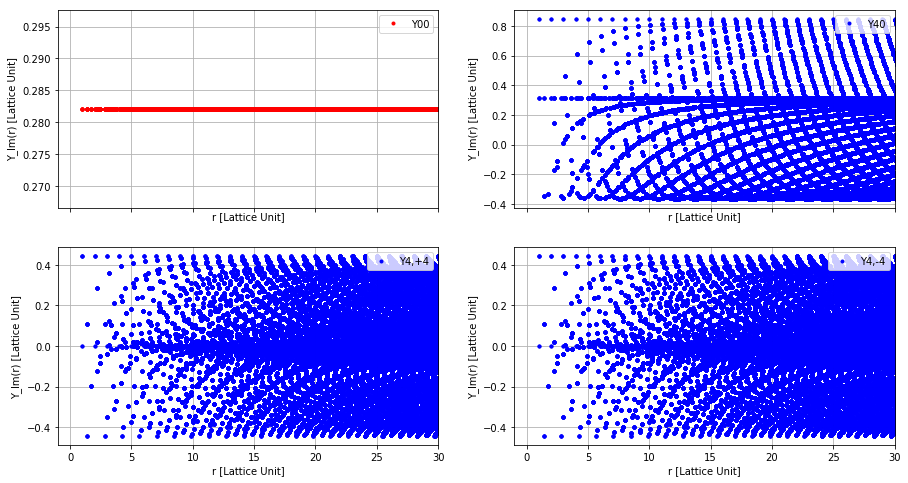

In [9]:
###=== 2-D plot for the Y_lm(r) ===###

if (show_graph or True):
    r_flt    = rcrd.flatten()
    fig, axe = plt.subplots(ncols=2, nrows=2, figsize=(15,8), sharex=True)
    axe[0,0].plot(r_flt,Y00 .flatten().real,'r.', label='Y00')
    axe[0,1].plot(r_flt,Y40 .flatten().real,'b.', label='Y40')
    axe[1,0].plot(r_flt,Y4m4.flatten().real,'b.', label='Y4,+4')
    axe[1,1].plot(r_flt,Y4p4.flatten().real,'b.', label='Y4,-4')
    axe[0,0].set_xlim(-1,30)
    for i in range(2):
        for j in range(2):
            axe[i,j].grid(True)
            axe[i,j].legend(numpoints=1, loc='upper right')
            axe[i,j].set_ylabel('Y_lm(r) [Lattice Unit]')
            axe[i,j].set_xlabel('r [Lattice Unit]')

## Plot: 3-D plot for the spherical harmonicses ($Re[Y_{40}]$)

In [10]:
###=== 3-D plot for the spherical harmonicses (Y_40) ===###

if (show_graph or True):
    Nsp  = 6; lll = 4; mmm = 0
    Lsp  = 96/Nsp
    Lspa = np.arange(Lsp, dtype=int)
    Lspp = np.array([(i if i < Lsp//2 else i-Lsp) for i in Lspa], dtype=int)
    pd   = np.array([[sph_harm_xyz(lll,mmm, Lspp,Lspp[y],Lspp[z]) for y in Lspa] for z in Lspa])
    pd[np.isnan(pd)] = 0.0
    p = [
        np.array([[[Lspp[x] for x in Lspa] for y in Lspa] for z in Lspa]).flatten() * Nsp,
        np.array([[[Lspp[y] for x in Lspa] for y in Lspa] for z in Lspa]).flatten() * Nsp,
        np.array([[[Lspp[z] for x in Lspa] for y in Lspa] for z in Lspa]).flatten() * Nsp,
        pd.flatten().real
    ]
    offline.iplot(dict(data=[go.Scatter3d(x=p[0],y=p[1],z=p[2], mode='markers',
                                          marker=dict(color=p[3], 
                                                      size=abs(p[3])*20,
                                                      colorscale='Jet', 
                                                      opacity=0.4, 
                                                      showscale=True))],
                       layout=dict(margin=dict(l=0,r=0,b=0,t=0))))

## Plot: 3-D plot for the spherical harmonicses ($Re[Y_{4,-4}]$) 

In [11]:
###=== 3-D plot for the spherical harmonicses (Y_4,-4) ===###

if (show_graph or True):
    Nsp  = 6; lll = 4; mmm = -4
    Lsp  = 96/Nsp
    Lspa = np.arange(Lsp, dtype=int)
    Lspp = np.array([(i if i < Lsp//2 else i-Lsp) for i in Lspa], dtype=int)
    pd   = np.array([[sph_harm_xyz(lll,mmm, Lspp,Lspp[y],Lspp[z]) for y in Lspa] for z in Lspa])
    pd[np.isnan(pd)] = 0.0
    p = [
        np.array([[[Lspp[x] for x in Lspa] for y in Lspa] for z in Lspa]).flatten() * Nsp,
        np.array([[[Lspp[y] for x in Lspa] for y in Lspa] for z in Lspa]).flatten() * Nsp,
        np.array([[[Lspp[z] for x in Lspa] for y in Lspa] for z in Lspa]).flatten() * Nsp,
        pd.flatten().real
    ]
    offline.iplot(dict(data=[go.Scatter3d(x=p[0],y=p[1],z=p[2], mode='markers',
                                          marker=dict(color=p[3], 
                                                      size=abs(p[3])*20,
                                                      colorscale='Jet', 
                                                      opacity=0.4, 
                                                      showscale=True))],
                       layout=dict(margin=dict(l=0,r=0,b=0,t=0))))

# Wave functions with spherical harmonics

* The wave function without $Y_4$ contamination
\begin{equation}
\psi_{0}(r) = Y_0^0 (r) \psi(r)
\end{equation}


* The wave function with $Y_4$ contamination
<font size=3 color=red>
\begin{equation}
\psi_{4,m}(r) = Y_0^0 (r) \psi(r) + 0.01 Y_4^m (r) \psi(r),
\end{equation}
</font>
where $m = -4, 0, +4$

In [12]:
###=== Generate wave functions with the spherical harmonicses (L = 0 and/or 4) on the 3D-lattice ===###

Ncontami = 0.01
psi_0    = Y00  * psi
psi_40   = Y00  * psi + Ncontami * Y40  * psi
psi_4m4  = Y00  * psi + Ncontami * Y4m4 * psi
psi_4p4  = Y00  * psi + Ncontami * Y4p4 * psi

## Plot: 2-D plot for the wave functions with the spherical harmonicses

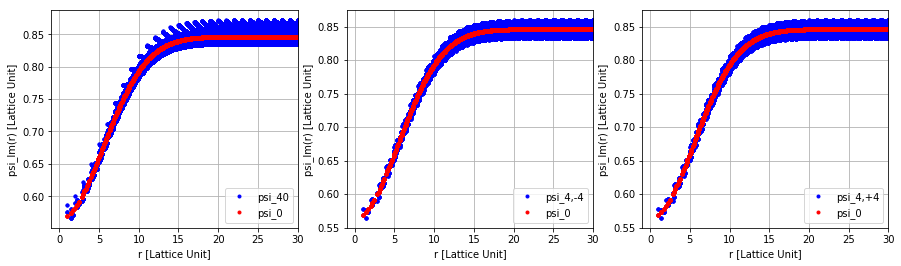

In [13]:
###=== 2-D plot for the wave functions with the spherical harmonicses  ===###

if (show_graph or True):
    r_flt    = rcrd.flatten()
    fig, axe = plt.subplots(ncols=3, figsize=(15,4), sharex=True)
    
    axe[0].plot(r_flt,psi_40 .flatten().real,'b.', label='psi_40')
    axe[1].plot(r_flt,psi_4m4.flatten().real,'b.', label='psi_4,-4')
    axe[2].plot(r_flt,psi_4p4.flatten().real,'b.', label='psi_4,+4')
    axe[0].set_xlim(-1,30)
    for i in range(3):
        axe[i].plot(r_flt,psi_0.flatten().real,'r.', label='psi_0')
        axe[i].grid(True)
        axe[i].legend(numpoints=1, loc='lower right')
        axe[i].set_ylabel('psi_lm(r) [Lattice Unit]')
        axe[i].set_xlabel('r [Lattice Unit]')

# The potential with $Y_{l=4}$ contamination

* The potentials are defined by
<font size=3 color=red>
\begin{equation}
V_X = \frac{\nabla^2 \psi_X(r)}{\psi_X(r)},
\end{equation}
</font>
where $X = 0$ or $4,0$ or $4,-4$ or $4,+4$

In [14]:
###=== Generate potentials with Y4 contamination on the 3D-lattice ===###

pot_0   = lap_4th_proc(psi_0  )/psi_0
pot_40  = lap_4th_proc(psi_40 )/psi_40
pot_4m4 = lap_4th_proc(psi_4m4)/psi_4m4
pot_4p4 = lap_4th_proc(psi_4p4)/psi_4p4

## Plot: 2-D plot for the potentials with Y4 contamination

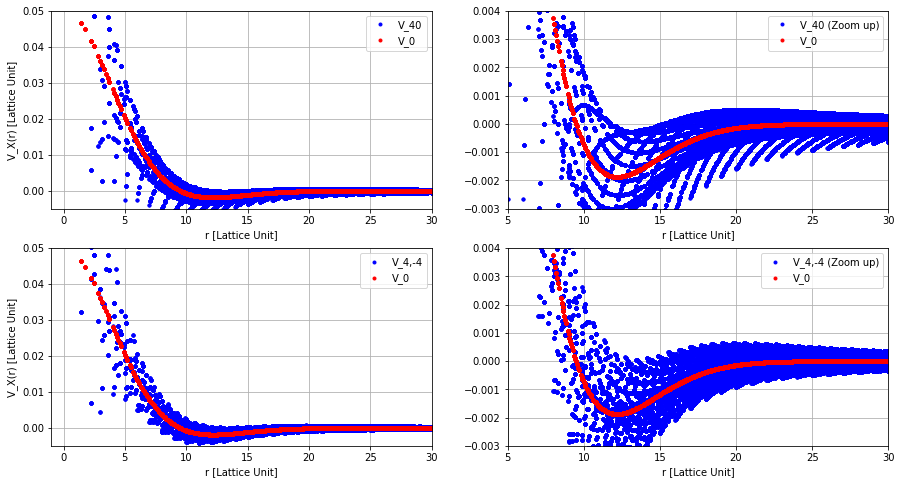

In [15]:
###=== 2-D plot for the potentials with Y4 contamination  ===###

if (show_graph or True):
    r_flt    = rcrd.flatten()
    fig, axe = plt.subplots(ncols=2, nrows=2, figsize=(15,8))
    axe[0,0].plot(r_flt,pot_40 .flatten().real,'b.', label='V_40')
    axe[0,1].plot(r_flt,pot_40 .flatten().real,'b.', label='V_40 (Zoom up)')
    axe[1,0].plot(r_flt,pot_4p4.flatten().real,'b.', label='V_4,-4')
    axe[1,1].plot(r_flt,pot_4p4.flatten().real,'b.', label='V_4,-4 (Zoom up)')
    for i in range(2):
        axe[i,0].set_xlim(-1,30)
        axe[i,0].set_ylim(-0.005,0.05)
        axe[i,0].set_ylabel('V_X(r) [Lattice Unit]')
        axe[i,1].set_xlim(5,30)
        axe[i,1].set_ylim(-3e-3,4e-3)
        for j in range(2):
            axe[i,j].plot(r_flt,pot_0.flatten().real,'r.', label='V_0')
            axe[i,j].grid(True)
            axe[i,j].legend(numpoints=1, loc='upper right')
            axe[i,j].set_xlabel('r [Lattice Unit]')

# $A_1$ projection for the spherical harmonics

In [16]:
Y00_A1  = rot_proj(Y00 , a_state="A1")
Y40_A1  = rot_proj(Y40 , a_state="A1")
Y4m4_A1 = rot_proj(Y4m4, a_state="A1")
Y4p4_A1 = rot_proj(Y4p4, a_state="A1")

## Plot: 2-D plot for the A1 projected spherical harmonics

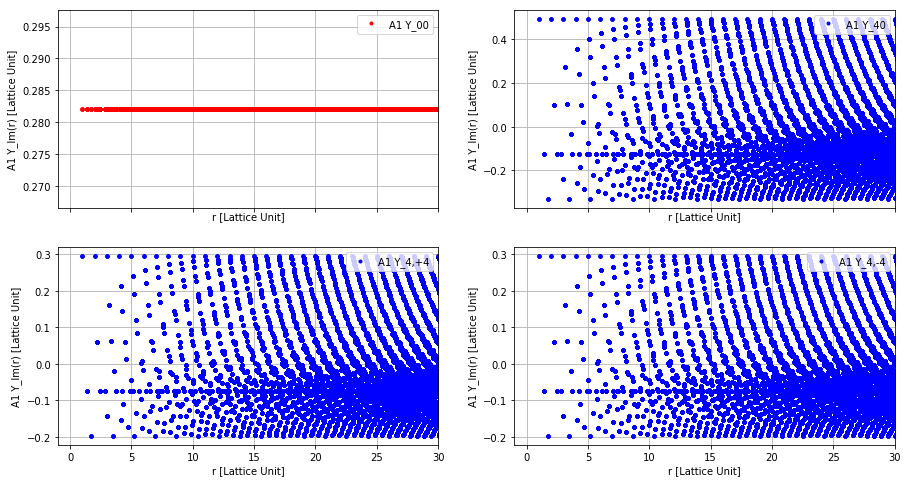

In [17]:
###=== 2-D plot for the A1 projected spherical harmonics ===###

if (show_graph or True):
    r_flt    = rcrd.flatten()
    fig, axe = plt.subplots(ncols=2, nrows=2, figsize=(15,8), sharex=True)
    axe[0,0].plot(r_flt,Y00_A1 .flatten().real,'r.', label='A1 Y_00')
    axe[0,1].plot(r_flt,Y40_A1 .flatten().real,'b.', label='A1 Y_40')
    axe[1,0].plot(r_flt,Y4m4_A1.flatten().real,'b.', label='A1 Y_4,+4')
    axe[1,1].plot(r_flt,Y4p4_A1.flatten().real,'b.', label='A1 Y_4,-4')
    axe[0,0].set_xlim(-1,30)
    for i in range(2):
        for j in range(2):
            axe[i,j].grid(True)
            #axe[i,j].set_ylim(-0.005,0.05)
            axe[i,j].legend(numpoints=1, loc='upper right')
            axe[i,j].set_ylabel('A1 Y_lm(r) [Lattice Unit]')
            axe[i,j].set_xlabel('r [Lattice Unit]')

## Plot: 2-D plot for the A1 projected spherical harmonics (ratio of $Y_{40}$ and $Y_{4,\pm4}$)

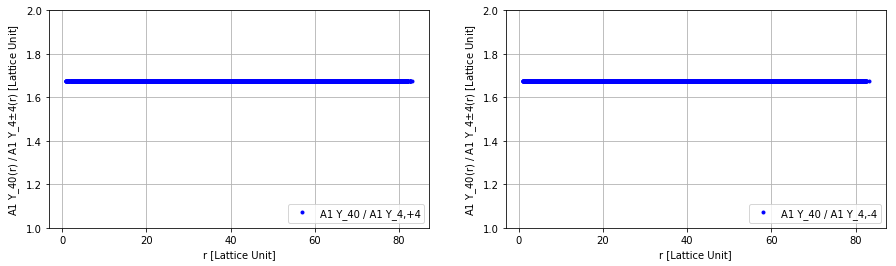

In [18]:
###=== 2-D plot for the A1 projected spherical harmonics (ratio of Y40 and Y4,+/-4) ===###

if (show_graph or True):
    r_flt    = rcrd .flatten()
    fig, axe = plt.subplots(ncols=2, figsize=(15,4), sharex=True)
    axe[0].plot(r_flt,Y40_A1.flatten().real/Y4p4_A1.flatten().real,'b.', label='A1 Y_40 / A1 Y_4,+4')
    axe[1].plot(r_flt,Y40_A1.flatten().real/Y4m4_A1.flatten().real,'b.', label='A1 Y_40 / A1 Y_4,-4')
    #axe[0].set_xlim(-1,40)
    for i in range(2):
        axe[i].grid(True)
        axe[i].set_ylim(1,2)
        axe[i].legend(numpoints=1, loc='lower right')
        axe[i].set_ylabel('A1 Y_40(r) / A1 Y_4$\pm$4(r) [Lattice Unit]')
        axe[i].set_xlabel('r [Lattice Unit]')

## A1 projection for the spherical harmonics (by hand)

* convert indicies $(x,y,z) \to (x,z,-y), (-z,y,x), \cdots$ and sum them


* $l = 4$, $m = 0$
\begin{equation}
P^{A1} Y_4^0(x,y,z) = \frac{21}{\sqrt{\pi}} \frac{x^4+y^4+z^4-3(x^2y^2+x^2z^2+y^2z^2)}{r^4}
\end{equation}


* $l = 4$, $m = \pm4$
\begin{equation}
P^{A1} Y_4^{\pm4}(x,y,z) = 3\sqrt{\frac{35}{2\pi}} \frac{x^4+y^4+z^4-3(x^2y^2+x^2z^2+y^2z^2)}{r^4}
\end{equation}


* Ratio
\begin{equation}
\frac{P^{A1} Y_4^0(x,y,z)}{P^{A1} Y_4^{\pm4}(x,y,z)} = \frac{\frac{21}{\sqrt{\pi}}}{3\sqrt{\frac{35}{2\pi}}} = \frac{14}{5} = 1.67332
\end{equation}

## Plot: 3-D plot for the A1 spherical harmonicses ($Re[Y_{40}]$)

In [19]:
###=== 3-D plot for the A1 spherical harmonicses (Y_40) ===###

if (show_graph or True):
    Nsp  = 6; lll = 4; mmm = 0
    Lsp  = 96/Nsp
    Lspa = np.arange(Lsp, dtype=int)
    Lspp = np.array([(i if i < Lsp//2 else i-Lsp) for i in Lspa], dtype=int)
    pd   = np.array([[sph_harm_xyz(lll,mmm, Lspp,Lspp[y],Lspp[z]) for y in Lspa] for z in Lspa])
    pd   = rot_proj(pd, a_state="A1")
    pd[np.isnan(pd)] = 0.0
    p = [
        np.array([[[Lspp[x] for x in Lspa] for y in Lspa] for z in Lspa]).flatten() * Nsp,
        np.array([[[Lspp[y] for x in Lspa] for y in Lspa] for z in Lspa]).flatten() * Nsp,
        np.array([[[Lspp[z] for x in Lspa] for y in Lspa] for z in Lspa]).flatten() * Nsp,
        pd.flatten().real
    ]
    offline.iplot(dict(data=[go.Scatter3d(x=p[0],y=p[1],z=p[2], mode='markers',
                                          marker=dict(color=p[3], 
                                                      size=abs(p[3])*30,
                                                      colorscale='Jet', 
                                                      opacity=0.4, 
                                                      showscale=True))],
                       layout=dict(margin=dict(l=0,r=0,b=0,t=0))))

## Plot: 3-D plot for the A1 spherical harmonicses ($Re[Y_{4,-4}]$)

In [20]:
###=== 3-D plot for the A1 spherical harmonicses (Y_4,-4) ===###

if (show_graph or True):
    Nsp  = 6; lll = 4; mmm = -4
    Lsp  = 96/Nsp
    Lspa = np.arange(Lsp, dtype=int)
    Lspp = np.array([(i if i < Lsp//2 else i-Lsp) for i in Lspa], dtype=int)
    pd   = np.array([[sph_harm_xyz(lll,mmm, Lspp,Lspp[y],Lspp[z]) for y in Lspa] for z in Lspa])
    pd   = rot_proj(pd, a_state="A1")
    pd[np.isnan(pd)] = 0.0
    p = [
        np.array([[[Lspp[x] for x in Lspa] for y in Lspa] for z in Lspa]).flatten() * Nsp,
        np.array([[[Lspp[y] for x in Lspa] for y in Lspa] for z in Lspa]).flatten() * Nsp,
        np.array([[[Lspp[z] for x in Lspa] for y in Lspa] for z in Lspa]).flatten() * Nsp,
        pd.flatten().real
    ]
    offline.iplot(dict(data=[go.Scatter3d(x=p[0],y=p[1],z=p[2], mode='markers',
                                          marker=dict(color=p[3], 
                                                      size=abs(p[3])*30,
                                                      colorscale='Jet', 
                                                      opacity=0.4, 
                                                      showscale=True))],
                       layout=dict(margin=dict(l=0,r=0,b=0,t=0))))

## Appendix: A1 projection for various $Y_{l,m}$

* I found that only $Re[Y_{lm}]$ at $l =$ even and $m = 4n~~(n=0,1,2,\cdots)$ are survive in A1 projection (I have checked up to $l=16$)
* I also found that $Y_{4,0} \propto Y_{4,\pm4}$

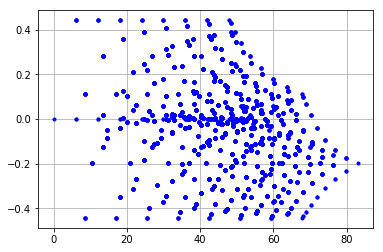

In [21]:
if (True):
    Nsp  = 6; lll = 4; mmm = 4
    Lsp  = 96/Nsp
    Lspa = np.arange(Lsp, dtype=int)
    Lspp = np.array([(i if i < Lsp//2 else i-Lsp) for i in Lspa], dtype=int)
    rcsp = np.array([[np.sqrt(Lspp**2 + Lspp[y]**2 + Lspp[z]**2) for y in Lspa] for z in Lspa])
    pd   = np.array([[sph_harm_xyz(lll,mmm, Lspp,Lspp[y],Lspp[z]) for y in Lspa] for z in Lspa])
    #pd   = rot_proj(pd, a_state="A1")
    pd[np.isnan(pd)] = 0.0
    p = [
        np.array([[[Lspp[x] for x in Lspa] for y in Lspa] for z in Lspa]).flatten() * Nsp,
        np.array([[[Lspp[y] for x in Lspa] for y in Lspa] for z in Lspa]).flatten() * Nsp,
        np.array([[[Lspp[z] for x in Lspa] for y in Lspa] for z in Lspa]).flatten() * Nsp,
        pd.flatten().real
    ]
    plt.plot(rcsp.flatten()*Nsp,pd.flatten().real,'b.'); plt.grid(True)
    offline.iplot(dict(data=[go.Scatter3d(x=p[0],y=p[1],z=p[2], mode='markers',
                                          marker=dict(color=p[3], 
                                                      size=abs(p[3])*40,
                                                      colorscale='Jet', 
                                                      opacity=0.4, 
                                                      showscale=True))],
                       layout=dict(margin=dict(l=0,r=0,b=0,t=0))))

# $A_1$ projection for the wave function

In [22]:
psi_0_A1   = rot_proj(psi_0  , a_state="A1")
psi_40_A1  = rot_proj(psi_40 , a_state="A1")
psi_4m4_A1 = rot_proj(psi_4m4, a_state="A1")
psi_4p4_A1 = rot_proj(psi_4p4, a_state="A1")

## Plot: 2-D plot for the A1 projected wave function

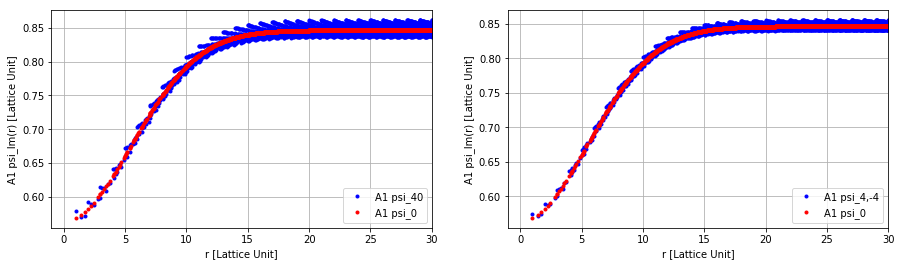

In [23]:
###=== 2-D plot for the A1 projected wave function  ===###

if (show_graph or True):
    redr = make_rd(psi_40_A1.real)[0]
    fig, axe = plt.subplots(ncols=2, figsize=(15,4), sharex=True)
    axe[0].plot(redr,make_rd(psi_40_A1 .real)[1],'b.', label='A1 psi_40')
    axe[1].plot(redr,make_rd(psi_4m4_A1.real)[1],'b.', label='A1 psi_4,-4')
    axe[0].set_xlim(-1,30)
    for i in range(2):
        axe[i].plot(redr,make_rd(psi_0_A1.real)[1],'r.', label='A1 psi_0')
        axe[i].grid(True)
        #axe[i].set_ylim(-0.005,0.05)
        axe[i].legend(numpoints=1, loc='lower right')
        axe[i].set_ylabel('A1 psi_lm(r) [Lattice Unit]')
        axe[i].set_xlabel('r [Lattice Unit]')

# The A1 projected potential with $Y_{l=4}$ contamination

* The potentials are defined by
<font size=3 color=red>
\begin{equation}
V_X = \frac{\nabla^2 \psi_X(r)}{\psi_X(r)},
\end{equation}
</font>
where $X = 0$ or $4,0$ or $4,-4$ or $4,+4$

In [24]:
###=== Generate A1 projected potentials with Y4 contamination on the 3D-lattice ===###

pot_0_A1   = lap_4th_proc(psi_0_A1  )/psi_0_A1
pot_40_A1  = lap_4th_proc(psi_40_A1 )/psi_40_A1
pot_4m4_A1 = lap_4th_proc(psi_4m4_A1)/psi_4m4_A1
pot_4p4_A1 = lap_4th_proc(psi_4p4_A1)/psi_4p4_A1

## Plot: 2-D plot for the A1 projected potentials with Y4 contamination

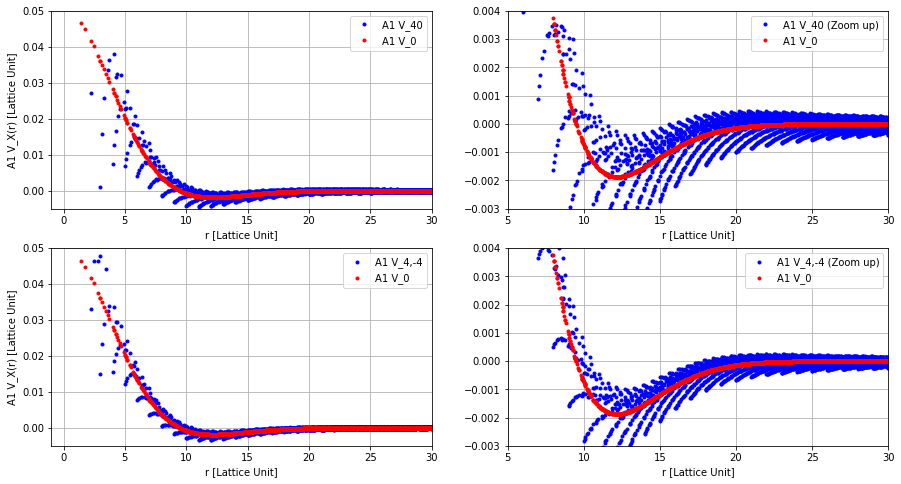

In [25]:
###=== 2-D plot for the A1 projected potentials with Y4 contamination  ===###

if (show_graph or True):
    redr = make_rd(pot_40_A1.real)[0]
    fig, axe = plt.subplots(ncols=2, nrows=2, figsize=(15,8))
    axe[0,0].plot(redr,make_rd(pot_40_A1 .real)[1],'b.', label='A1 V_40')
    axe[0,1].plot(redr,make_rd(pot_40_A1 .real)[1],'b.', label='A1 V_40 (Zoom up)')
    axe[1,0].plot(redr,make_rd(pot_4m4_A1.real)[1],'b.', label='A1 V_4,-4')
    axe[1,1].plot(redr,make_rd(pot_4m4_A1.real)[1],'b.', label='A1 V_4,-4 (Zoom up)')
    for i in range(2):
        axe[i,0].set_ylabel('A1 V_X(r) [Lattice Unit]')
        axe[i,0].set_xlim(-1,30)
        axe[i,0].set_ylim(-0.005,0.05)
        axe[i,1].set_xlim(5,30)
        axe[i,1].set_ylim(-3e-3,4e-3)    
        for j in range(2):
            axe[i,j].plot(redr,make_rd(pot_0_A1.real)[1],'r.', label='A1 V_0')
            axe[i,j].grid(True)
            axe[i,j].legend(numpoints=1, loc='upper right')
            axe[i,j].set_xlabel('r [Lattice Unit]')

## Plot: 2-D plot for the A1 projected potentials with Y4 contamination

* I have only taken the points in which A1 Y40 has small values

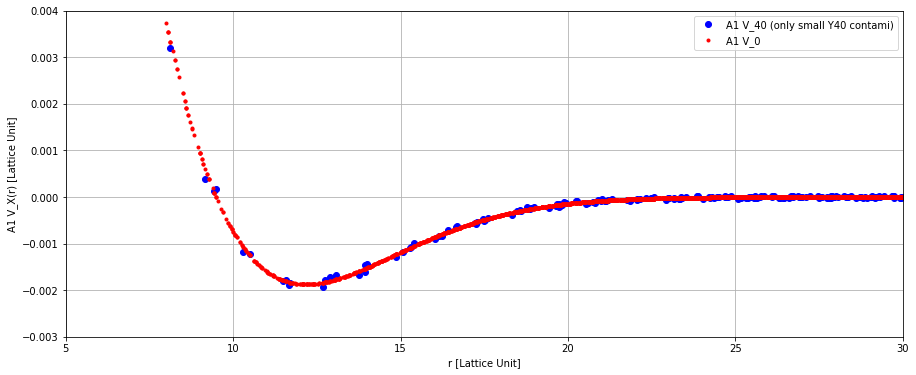

In [26]:
def A1_Y40(x,y,z):
    return (float(x**4+y**4+z**4-3*(x**2*y**2+x**2*z**2+y**2*z**2)) / float(x**2+y**2+z**2)**2)
def make_red_A1_Y40(idata, criterion = 0.05):
    o_r = []
    o_d = []
    for z in range(1,Ls//2+1):
        for y in range(z+1):
            for x in range(y+1):
                if (abs(A1_Y40(x,y,z)) < criterion):
                    o_r.append(np.sqrt(x**2+y**2+z**2))
                    o_d.append(idata[z,y,x].real)
    return np.array((o_r,o_d))

crits = (0.01, 0.05, 0.08, 0.1, 0.15, 0.2, 0.2, 0.3)
Ncrit = len(crits)
pot_red_A1_Y40_r = np.array([make_red_A1_Y40(pot_40_A1.real, crits[ic])[0] for ic in range(Ncrit)])
pot_red_A1_Y40_d = np.array([make_red_A1_Y40(pot_40_A1.real, crits[ic])[1] for ic in range(Ncrit)])

if (show_graph or True):
    fig, axe = plt.subplots(figsize=(15,6))
    axe.plot(pot_red_A1_Y40_r[1],pot_red_A1_Y40_d[1],'bo', label='A1 V_40 (only small Y40 contami)')
    axe.plot(make_rd(pot_0_A1.real)[0],make_rd(pot_0_A1.real)[1],'r.', label='A1 V_0')
    axe.set_xlim(5,30)
    axe.set_ylim(-3e-3,4e-3) 
    axe.grid(True)
    axe.legend(numpoints=1, loc='upper right')
    axe.set_xlabel('r [Lattice Unit]')
    axe.set_ylabel('A1 V_X(r) [Lattice Unit]')

In [27]:
if (show_graph or True):
    data  = [dict(visible=False, mode='markers', name='crit = '+str(crits[ic]),
                  x=pot_red_A1_Y40_r[ic][pot_red_A1_Y40_r[ic]<30], y=pot_red_A1_Y40_d[ic]) for ic in range(Ncrit)]
    data[0]['visible'] = True
    steps = []
    for i in range(len(data)):
        step = dict(method='restyle', args = ['visible', [False] * len(data)],)
        step['args'][1][i] = True
        steps.append(step)
    offline.iplot(dict(data=data,
                       layout=dict(margin=dict(l=60,r=60,b=120,t=60),
                                   yaxis={"range": [-3e-3, 4e-3]}, xaxis={"range": [5, 30]},
                                   sliders=[dict(active=10, steps=steps)])))

# r-binning for potential

* Nbin = 1

In [28]:
###=== Generate r-binning potential data on the 3D-lattice ===###

rbin_pot_0_A1   = rbin(np.array((rcrd.flatten(), pot_0_A1  .real.flatten())), bsize = 1)
rbin_pot_40_A1  = rbin(np.array((rcrd.flatten(), pot_40_A1 .real.flatten())), bsize = 1)
rbin_pot_4m4_A1 = rbin(np.array((rcrd.flatten(), pot_4m4_A1.real.flatten())), bsize = 1)
rbin_pot_4p4_A1 = rbin(np.array((rcrd.flatten(), pot_4p4_A1.real.flatten())), bsize = 1)

/home/miyamoto/local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning:

invalid value encountered in sqrt



## Plot: 2-D plot for the r-binned potentials with Y4 contamination

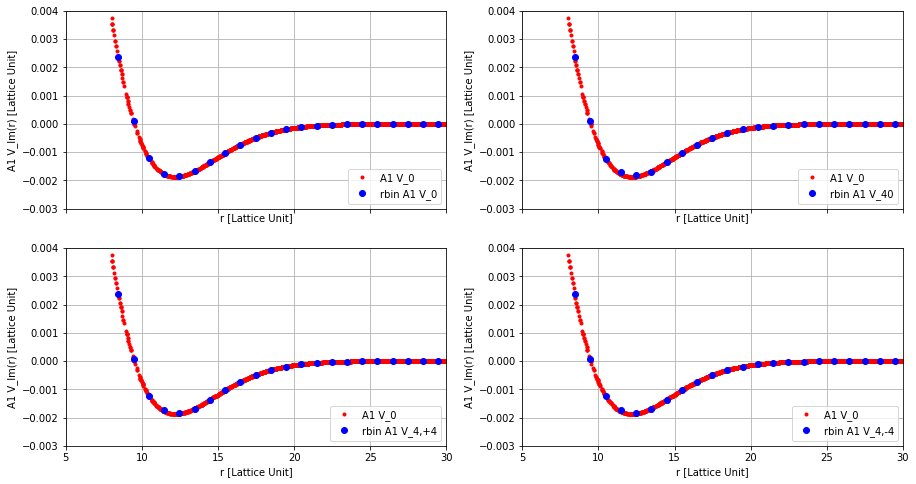

In [29]:
###=== 2-D plot for the r-binned potentials with Y4 contamination  ===###

if (show_graph or True):
    redr = make_rd(pot_0_A1.real)[0]
    fig, axe = plt.subplots(ncols=2, nrows=2, figsize=(15,8), sharex=True)
    for i in range(2):
        for j in range(2):
            axe[i,j].plot(redr,make_rd(pot_0_A1.real)[1],'r.', label='A1 V_0')
    axe[0,0].plot(rbin_pot_0_A1  [0],rbin_pot_0_A1  [1],'bo', label='rbin A1 V_0')
    axe[0,1].plot(rbin_pot_40_A1 [0],rbin_pot_40_A1 [1],'bo', label='rbin A1 V_40')
    axe[1,0].plot(rbin_pot_4p4_A1[0],rbin_pot_4p4_A1[1],'bo', label='rbin A1 V_4,+4')
    axe[1,1].plot(rbin_pot_4m4_A1[0],rbin_pot_4m4_A1[1],'bo', label='rbin A1 V_4,-4')
    axe[0,0].set_xlim(5,30)
    for i in range(2):
        for j in range(2):
            axe[i,j].grid(True)
            axe[i,j].set_ylim(-0.003,0.004)
            axe[i,j].legend(numpoints=1, loc='lower right')
            axe[i,j].set_ylabel('A1 V_lm(r) [Lattice Unit]')
            axe[i,j].set_xlabel('r [Lattice Unit]')

# r-binning for A1 projected $Y_{40}$

* Nbin = 1

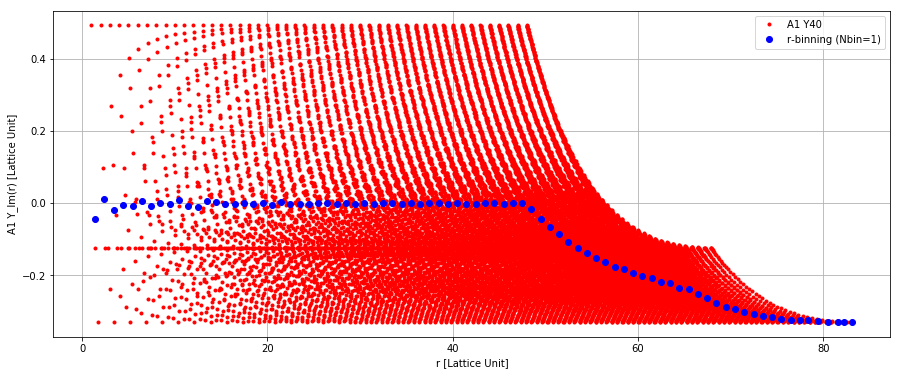

In [30]:
###=== 2-D plot for the r-binned Y40  ===###

if (show_graph or True):
    rbinY = rbin(np.array((rcrd.flatten(), Y40_A1.real.flatten())), bsize=1)
    redr  = make_rd(Y40_A1.real)[0]
    fig, axe = plt.subplots(figsize=(15,6), sharex=True)
    axe.plot(redr,make_rd(Y40_A1.real)[1], 'r.', label='A1 Y40')
    axe.plot(rbinY[0],rbinY[1], 'bo', label='r-binning (Nbin=1)')
    axe.grid(True)
    axe.legend(numpoints=1, loc='upper right')
    axe.set_ylabel('A1 Y_lm(r) [Lattice Unit]')
    axe.set_xlabel('r [Lattice Unit]')

## Plot: 2-D plot for the #.bin dependence

* Nbin = 0.05, 0.1, 0.3, 0.5, 1, 2, 5, 10

In [31]:
Nbins = (0.05, 0.1, 0.3, 0.5, 1, 2, 5, 10)
NNbin = len(Nbins)
rbin_Y40_A1_rs = np.array([rbin(np.array((rcrd.flatten(), Y40_A1.real.flatten())), bsize=Nbins[ibin])[0]
                           for ibin in range(NNbin)])
rbin_Y40_A1_ds = np.array([rbin(np.array((rcrd.flatten(), Y40_A1.real.flatten())), bsize=Nbins[ibin])[1]
                           for ibin in range(NNbin)])
rbin_Y40_A1_xes= np.array([rbin(np.array((rcrd.flatten(), Y40_A1.real.flatten())), bsize=Nbins[ibin])[2]
                           for ibin in range(NNbin)])
rbin_Y40_A1_yes= np.array([rbin(np.array((rcrd.flatten(), Y40_A1.real.flatten())), bsize=Nbins[ibin])[3]
                           for ibin in range(NNbin)])

/home/miyamoto/local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning:

invalid value encountered in sqrt

/home/miyamoto/local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning:

invalid value encountered in sqrt



In [32]:
###=== 2-D plot for the r-binned and A1 projected Y40 (#.bin dependence) ===###

if (show_graph or True):
    data  = [dict(visible=False, mode='markers', name='Nbin = '+str(Nbins[ibin]),
                  x=rbin_Y40_A1_rs[ibin][rbin_Y40_A1_rs[ibin]<30.0], 
                  y=rbin_Y40_A1_ds[ibin], 
                  error_y=dict(type='data', array=rbin_Y40_A1_yes[ibin],visible=True),
                  error_x=dict(type='data', array=rbin_Y40_A1_xes[ibin],visible=True))
             for ibin in range(NNbin)]
    data[0]['visible'] = True
    steps = []
    for i in range(len(data)):
        step = dict(method='restyle', args = ['visible', [False] * len(data)],)
        step['args'][1][i] = True
        steps.append(step)
    offline.iplot(dict(data=data,
                       layout=dict(margin=dict(l=60,r=60,b=120,t=60),
                                   yaxis={"range": [-0.3, 0.4]}, xaxis={"range": [0, 30]},
                                   sliders=[dict(active=10, steps=steps)])))

## Plot: The #.bin dependence for the potential with Y4 contamination

* Nbin = 0.05, 0.1, 0.3, 0.5, 1, 2, 5, 10

In [33]:
Nbins = (0.05, 0.1, 0.3, 0.5, 1, 2, 5, 10)
NNbin = len(Nbins)
rbin_pot_40_A1_rs = np.array([rbin(np.array((rcrd.flatten(), pot_40_A1.real.flatten())),
                                   bsize=Nbins[ibin])[0] for ibin in range(NNbin)])
rbin_pot_40_A1_ds = np.array([rbin(np.array((rcrd.flatten(), pot_40_A1.real.flatten())),
                                   bsize=Nbins[ibin])[1] for ibin in range(NNbin)])
rbin_pot_40_A1_xes= np.array([rbin(np.array((rcrd.flatten(), pot_40_A1.real.flatten())),
                                   bsize=Nbins[ibin])[2] for ibin in range(NNbin)])
rbin_pot_40_A1_yes= np.array([rbin(np.array((rcrd.flatten(), pot_40_A1.real.flatten())),
                                   bsize=Nbins[ibin])[3] for ibin in range(NNbin)])

/home/miyamoto/local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning:

invalid value encountered in sqrt

/home/miyamoto/local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning:

invalid value encountered in sqrt



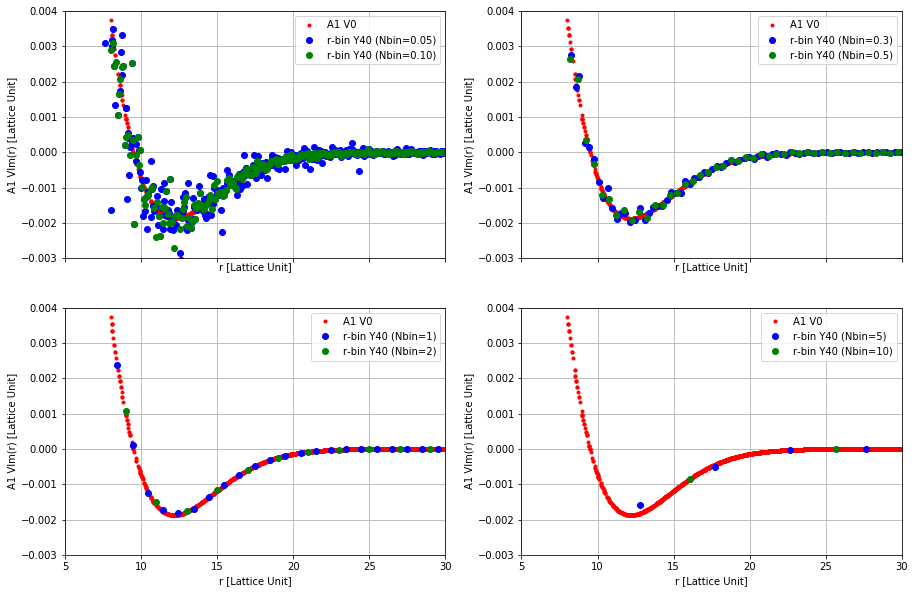

In [34]:
###=== 2-D plot for the r-binned and A1 projected V40 (#.bin dependence) ===###

if (show_graph or True):
    redr = make_rd(pot_0_A1.real)[0]
    fig, axe = plt.subplots(ncols=2, nrows=2, figsize=(15,10), sharex=True)
    fmt = ('bo', 'go')
    for i in range(2):
        for j in range(2):
            axe[i,j].plot(redr,make_rd(pot_0_A1.real)[1], 'r.', label='A1 V0')
    for ibin in (0,1):
        axe[0,0].plot(rbin_pot_40_A1_rs[ibin],rbin_pot_40_A1_ds[ibin], fmt[ibin], 
                      label='r-bin Y40 (Nbin=%2.2f)'%Nbins[ibin])
    for ibin in (2,3):
        axe[0,1].plot(rbin_pot_40_A1_rs[ibin],rbin_pot_40_A1_ds[ibin], fmt[ibin-2], 
                      label='r-bin Y40 (Nbin=%1.1f)'%Nbins[ibin])
    for ibin in (4,5):
        axe[1,0].plot(rbin_pot_40_A1_rs[ibin],rbin_pot_40_A1_ds[ibin], fmt[ibin-4], 
                      label='r-bin Y40 (Nbin=%d)'%Nbins[ibin])
    for ibin in (6,7):
        axe[1,1].plot(rbin_pot_40_A1_rs[ibin],rbin_pot_40_A1_ds[ibin], fmt[ibin-6], 
                      label='r-bin Y40 (Nbin=%d)'%Nbins[ibin])
    for i in range(2):
        for j in range(2):
            axe[i,j].grid(True)
            axe[i,j].legend(numpoints=1, loc='upper right')
            axe[i,j].set_ylabel('A1 Vlm(r) [Lattice Unit]')
            axe[i,j].set_xlabel('r [Lattice Unit]')
            axe[i,j].set_xlim(5,30)
            axe[i,j].set_ylim(-3e-3,4e-3)